In [2]:
# required libraries
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf

from letterbox import letterbox

In [19]:
def ImageBox(image, new_shape=(640, 640), color=(255, 0, 0)):

    
    width, height, channel = image.shape
    
    ratio = min(new_shape[0] / width, new_shape[1] / height)
    #print('ratio',ratio)
    new_unpad = int(round(height * ratio)), int(round(width * ratio))
    #print(new_unpad)
    dw, dh = (new_shape[0] - new_unpad[0])/2, (new_shape[1] - new_unpad[1])/2
    #print('dw',dw,'dh',dh) 18.0, 0.0
    if (height, width) != new_unpad:
        image = cv2.resize(image, new_unpad, interpolation=cv2.INTER_LINEAR)
    
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    
    return image, ratio, (dw, dh)

In [20]:
model_path = 'best_float32.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get model input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
r_img = cv2.imread('president.jpg')
image,ratio,dwdh = ImageBox(r_img)
image = np.expand_dims(image, axis=0)
image = np.ascontiguousarray(image)
input_data = image.astype(np.float32)/255

interpreter.set_tensor(input_details[0]["index"], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]["index"])[0]

In [22]:
output_data = output_data[:,output_data[4]>0.1].T
output_data = output_data[output_data[:, 1].argsort()]
output_data = output_data[output_data[:, 0].argsort()]
print(output_data.shape)

(93, 5)


[181, 133, 242, 210] 0.8
[308, 324, 363, 387] 0.72
[376, 111, 439, 194] 0.83
[408, 221, 465, 289] 0.78
[558, 266, 613, 335] 0.8
[575, 103, 626, 177] 0.72
[755, 103, 819, 176] 0.79
[875, 37, 933, 108] 0.76
[948, 142, 1004, 205] 0.7


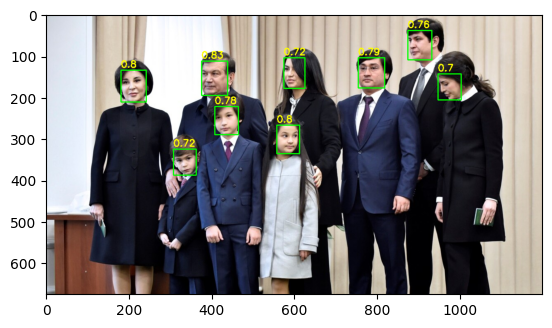

In [23]:
thresh = 0.5

for (x0, y0, x1, y1, scores) in output_data[output_data.shape[0]%9::9]:
    if scores > thresh:
        x0 -= dwdh[0]
        y0 -= dwdh[1]
        box = np.array([x0-x1/2, y0-y1/2, x0+x1/2, y0+y1/2])
        box /= ratio
        box = np.round(box).astype(np.int32).tolist()

        score = round(float(scores), 2)
        print(box, score)

        cv2.rectangle(r_img, box[:2], box[2:], (0,255,0), 2)
        cv2.putText(r_img, str(score), (box[0], box[1] - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [0, 255, 255], thickness=2)
            
plt.imshow(cv2.cvtColor(r_img, cv2.COLOR_BGR2RGB))
plt.show()

For video or webcam

In [5]:
model_path = 'best_float16.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get model input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
cap = cv2.VideoCapture(0)

if (cap.isOpened()== False):
    print("Error opening video file")

def ImageBox(image, new_shape=(640, 640), color=(255, 0, 0), auto=True, scaleup=True, stride=32):

    
    width, height, channel = image.shape
    
    ratio = min(new_shape[0] / width, new_shape[1] / height)
    #print('ratio',ratio)
    new_unpad = int(round(height * ratio)), int(round(width * ratio))
    #print(new_unpad)
    dw, dh = (new_shape[0] - new_unpad[0])/2, (new_shape[1] - new_unpad[1])/2
    #print('dw',dw,'dh',dh) 18.0, 0.0
    if (height, width) != new_unpad:
        image = cv2.resize(image, new_unpad, interpolation=cv2.INTER_LINEAR)
    
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    
    return image, ratio, (dw, dh)

thresh = 0.3
    
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        image, ratio, dwdh = ImageBox(frame, auto=True)
        image = np.expand_dims(image, 0)

        image = image.astype(np.float32) / 255.

        interpreter.set_tensor(input_details[0]["index"], image)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]["index"])[0]
        output_data = output_data[:,output_data[4]>0.1].T
        output_data = output_data[output_data[:, 1].argsort()]
        output_data = output_data[output_data[:, 0].argsort()]

        for (x0, y0, x1, y1, scores) in output_data[output_data.shape[0]%10::10]:
            if scores > thresh:
                x0 -= dwdh[0]
                y0 -= dwdh[1]
                box = np.array([x0-x1/2, y0-y1/2, x0+x1/2, y0+y1/2])
                box /= ratio
                box = np.round(box).astype(np.int32).tolist()

                score = round(float(scores), 2)

                cv2.rectangle(frame, box[:2], box[2:], (0,255,0), 2)
                cv2.putText(frame, str(score), (box[0], box[1] - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [0, 255, 255], thickness=2)
        
        cv2.imshow('Frame', frame)
        
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()